In [1]:
from notebooks.util.distribution_utils import *

from liquidity.response_functions.features import add_aggregate_features
from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Bin/window size for computing events
T = 1000

## Load market orders raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Orderflow

### 1.1. Size/ Volume

In [5]:
# Order size/ volume
size_volume = {'TSLA': tsla_raw_df['norm_trade_volume'],
               'MSFT': amzn_raw_df['norm_trade_volume'],
               'AMZN': nflx_raw_df['norm_trade_volume'],
               'NFLX': msft_raw_df['norm_trade_volume'],
               'EBAY': ebay_raw_df['norm_trade_volume'],
               'APPL': appl_raw_df['norm_trade_volume'],
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in size_volume.items()}

#### Stationarity Test

In [6]:
# ADF test
for stock, data in size_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -56.98
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -54.80
p-value: 0.00,
N: 499899, 
critical values: {'1%': -3.4303630813095825, '5%': -2.8615457817848604, '10%': -2.5667730774328796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -74.32
p-value: 0.00,
N: 499928, 
critical values: {'1%': -3.4303630805507535, '5%': -2.861545781449468, '10%': -2.5667730772543624}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -52.22
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



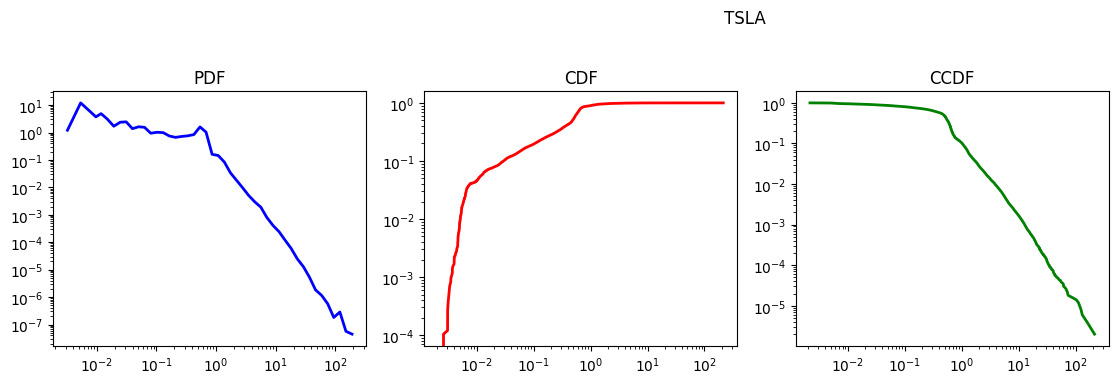

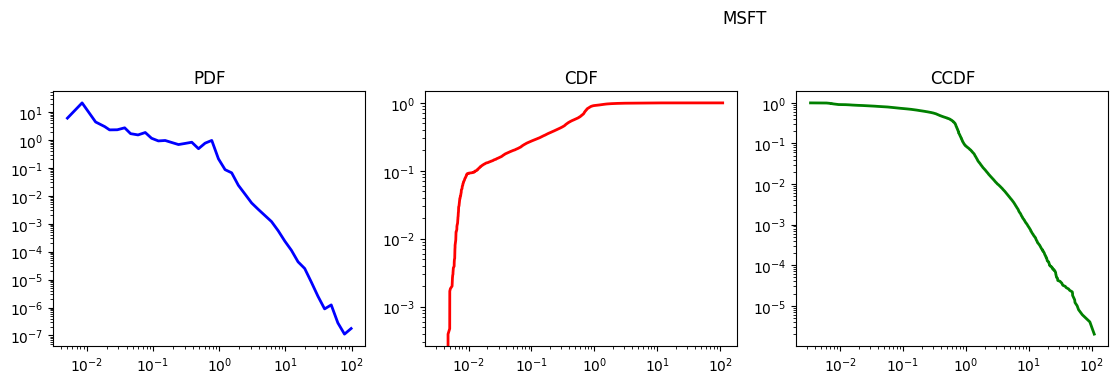

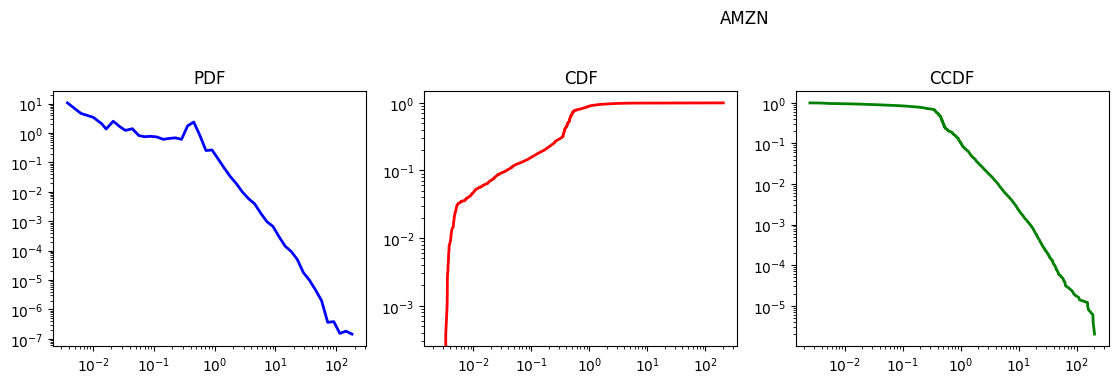

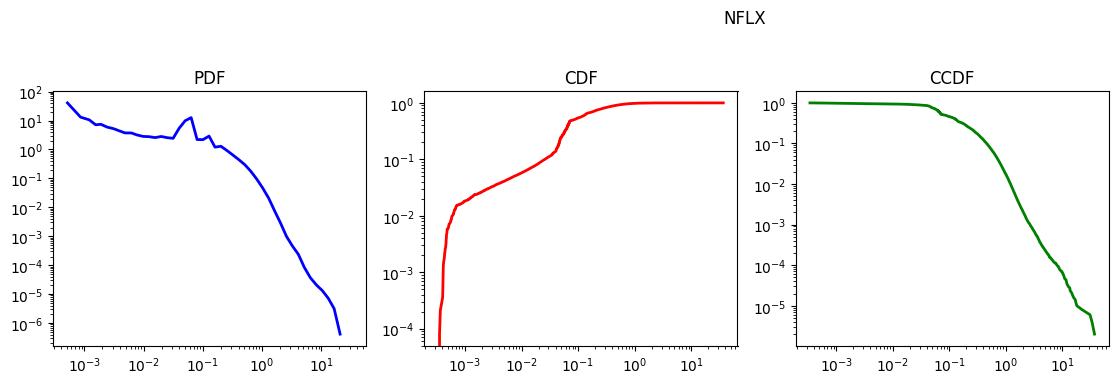

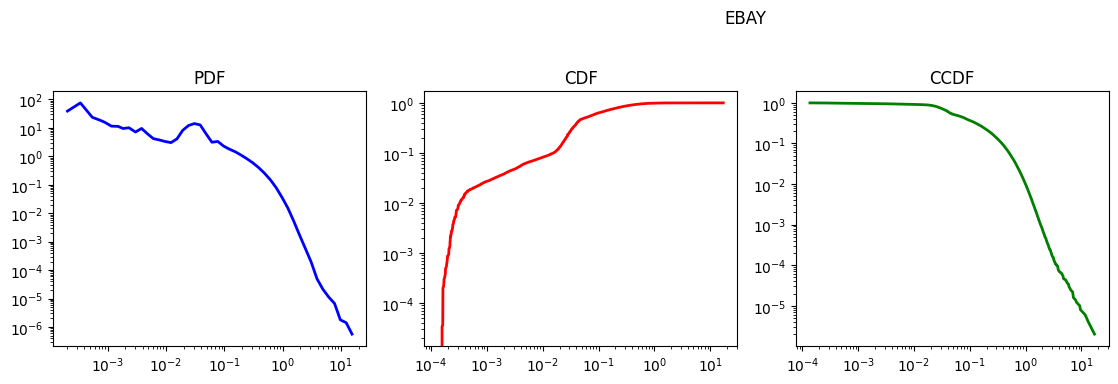

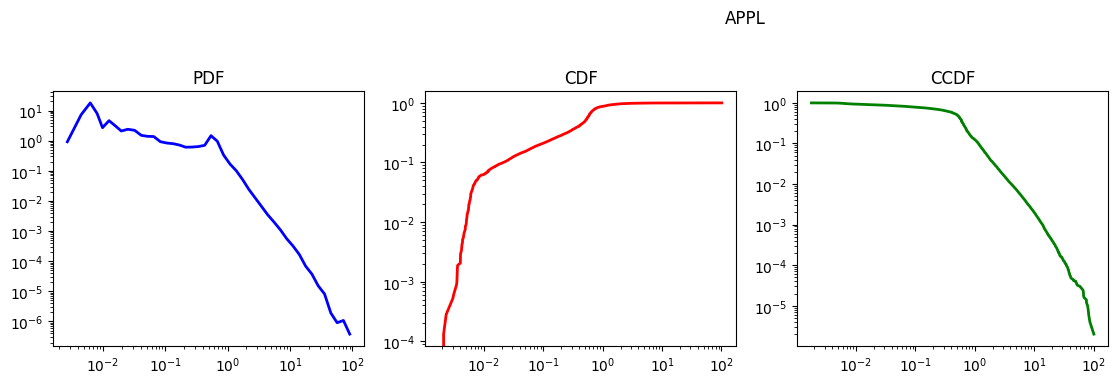

In [7]:
# Plot distribution of size_volume for each stock
for stock_name, data in size_volume.items():
    plot_distributions(stock_name, data)

### 1.2. Fit power law distribution

In [8]:
# 1. Fit Powerlaw and retrieve fitted object/ results
size_volume_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_size_volume_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(size_volume_data):
    volume_fit_objects = fit_powerlaw(data_dict=size_volume, filename=size_volume_data)
else:
    volume_fit_objects = load_fit_objects(size_volume_data)

volume_fit_objects

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x16ca303d0>,
 'MSFT': <powerlaw.Fit at 0x16c343410>,
 'AMZN': <powerlaw.Fit at 0x16c285a10>,
 'NFLX': <powerlaw.Fit at 0x16c286850>,
 'EBAY': <powerlaw.Fit at 0x16c343350>,
 'APPL': <powerlaw.Fit at 0x16c340310>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1507: RuntimeWarning: overflow encountered in divide
  likelihoods = f/C
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overf

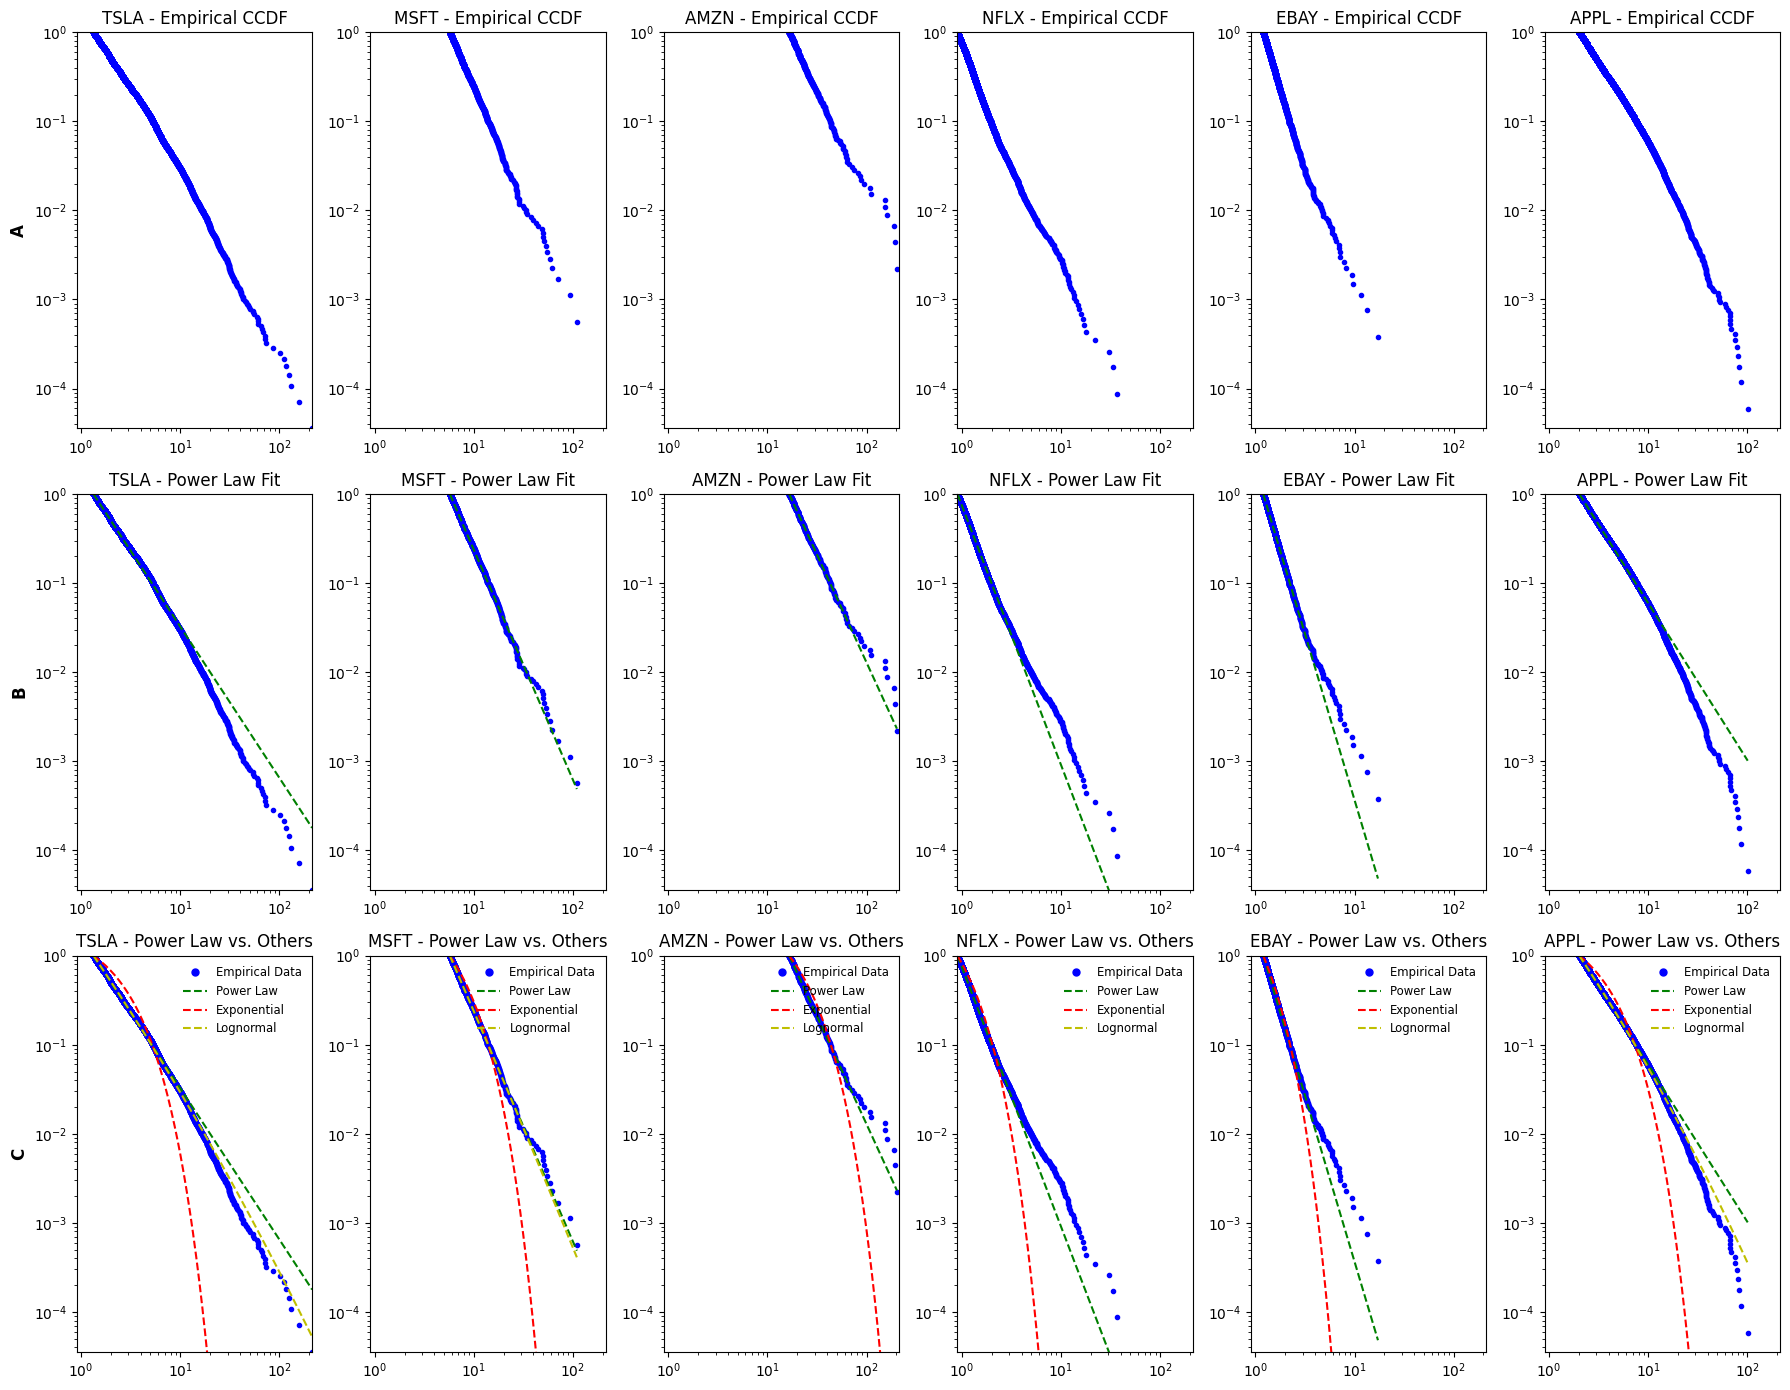

In [9]:
# Plot fitted objects
plot_fit_objects(volume_fit_objects)

#### 1.2.1 Retrieve Power law fitting results

In [10]:
# Get fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'power_law')
print(volume_fit_results)

  Stock Distribution     alpha       xmin  KS Distance
0  TSLA    power_law  2.699226   1.331031     0.013475
1  MSFT    power_law  3.584448   5.724803     0.014714
2  AMZN    power_law  3.424404  16.583772     0.019622
3  NFLX    power_law  3.913085   0.903732     0.016361
4  EBAY    power_law  4.731432   1.199784     0.011753
5  APPL    power_law  2.762073   2.019300     0.013576


In [11]:
# Average Alpha exponents across stocks
min_alpha = volume_fit_results['alpha'].min()
max_alpha = volume_fit_results['alpha'].max()
avg_alpha = volume_fit_results['alpha'].mean()
std_dev_alpha = volume_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.6992264537102493
Max Alpha: 4.731432050925461
Average Alpha: 3.5191114837631017
std_dev_alpha: 0.7594067170542216


#### 1.2.2. Compare alternative distributions

In [12]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_comparison = distribution_compare(volume_fit_objects, 'exponential')
display(volume_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,0.591642,1.331031,2.699226,0.013475,0.180223,19.449909,2.919507e-84
1,MSFT,exponential,0.279612,5.724803,3.584448,0.014714,0.123475,4.817648,1.452601e-06
2,AMZN,exponential,0.084990,16.583772,3.424404,0.019622,0.145432,3.559224,3.719529e-04
3,NFLX,exponential,2.030761,0.903732,3.913085,0.016361,0.109303,10.158266,3.044429e-24
4,EBAY,exponential,2.213381,1.199784,4.731432,0.011753,0.087149,4.892975,9.932305e-07
5,APPL,exponential,0.431947,2.019300,2.762073,0.013576,0.155928,18.496887,2.187503e-76


## 2. Signed Ordeflow Imbalance

In [48]:
# Aggregate orderflow
tsla_aggregate_orderflow = add_aggregate_features(tsla_raw_df, [T], remove_outliers=False)
msft_aggregate_orderflow = add_aggregate_features(msft_raw_df, [T], remove_outliers=False)
amzn_aggregate_orderflow = add_aggregate_features(amzn_raw_df, [T], remove_outliers=False)
nflx_aggregate_orderflow = add_aggregate_features(nflx_raw_df, [T],remove_outliers=False)
ebay_aggregate_orderflow = add_aggregate_features(ebay_raw_df, [T], remove_outliers=False)
appl_aggregate_orderflow = add_aggregate_features(appl_raw_df, [T],remove_outliers=False)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}


# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'],
 'MSFT': msft_aggregate_orderflow['vol_imbalance'],
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'],
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'],
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'],
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}
#volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

### Stationarity Tests

In [49]:
# sign_imbalance ADF test
print('Order-sign Imbalance')
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)
print('\n')


Order-sign Imbalance
TSLA
ADF: -5.67
p-value: 0.00,
N: 750, 
critical values: {'1%': -3.439099096730074, '5%': -2.8654013553540745, '10%': -2.568826193777778}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -12.72
p-value: 0.00,
N: 1524, 
critical values: {'1%': -3.4346481290263013, '5%': -2.8634383565975736, '10%': -2.567780658251872}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -7.09
p-value: 0.00,
N: 1007, 
critical values: {'1%': -3.436860474327014, '5%': -2.8644144230916537, '10%': -2.568300476140699}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -11.86
p-value: 0.00,
N: 1627, 
critical values: {'1%': -3.4343755975140455, '5%': -2.8633180685073194, '10%': -2.5677166050955584}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stati

In [50]:
# volume_imbalance ADF test
print('Signed-volume Imbalance')
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

Signed-volume Imbalance
TSLA
ADF: -13.81
p-value: 0.00,
N: 756, 
critical values: {'1%': -3.439029421541435, '5%': -2.8653706489231876, '10%': -2.568809835460933}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -17.21
p-value: 0.00,
N: 1526, 
critical values: {'1%': -3.4346424863111396, '5%': -2.8634358661653803, '10%': -2.5677793320839823}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -13.82
p-value: 0.00,
N: 1013, 
critical values: {'1%': -3.436821814402523, '5%': -2.8643973728364043, '10%': -2.5682913948189823}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -9.04
p-value: 0.00,
N: 1610, 
critical values: {'1%': -3.4344181718827462, '5%': -2.8633368604103104, '10%': -2.567726611627638}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be 

### 2.1. Order Sign Imbalance

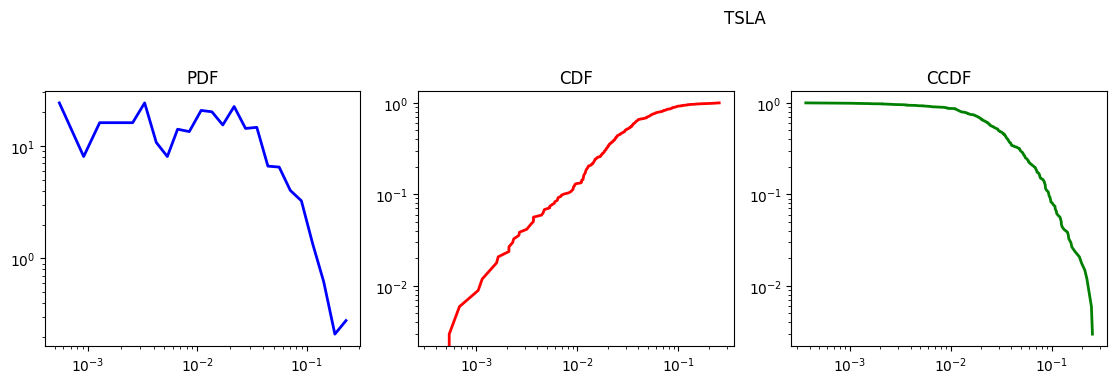

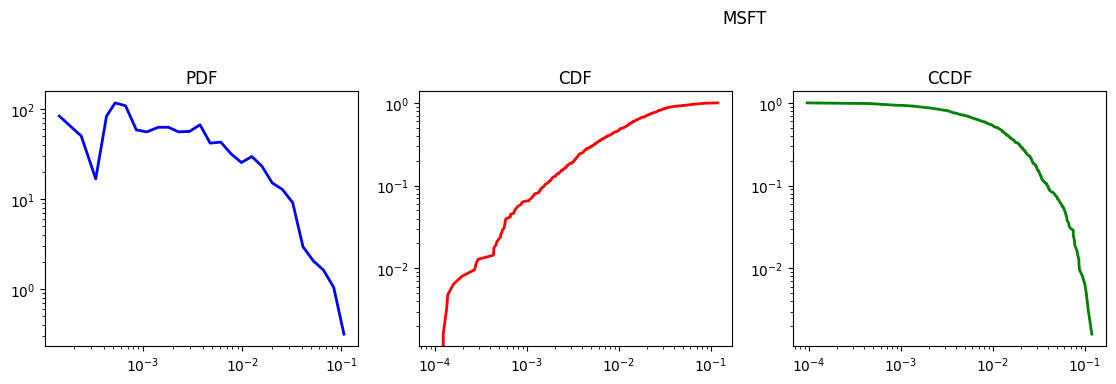

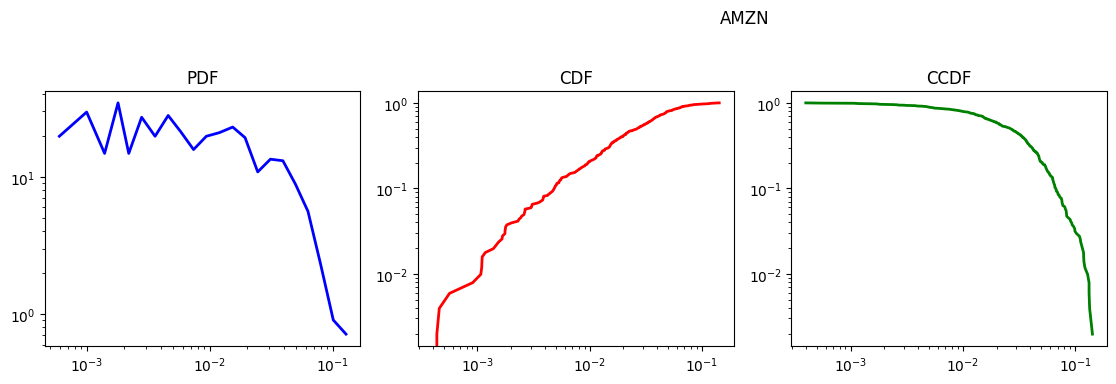

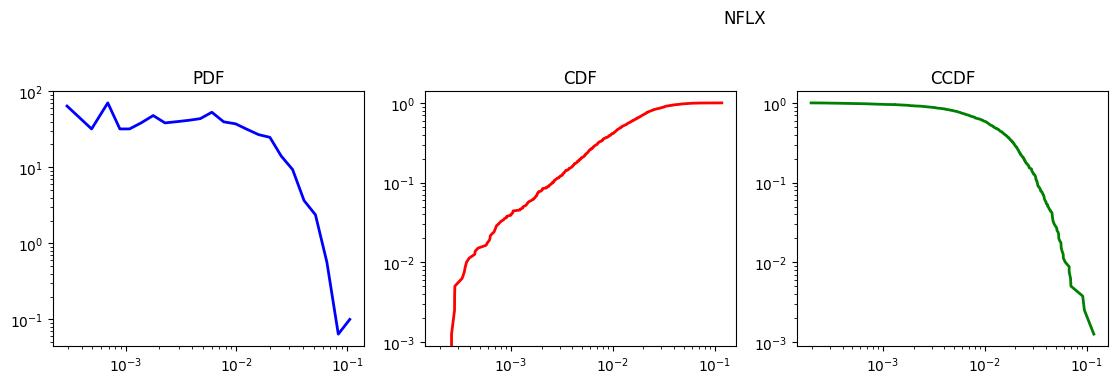

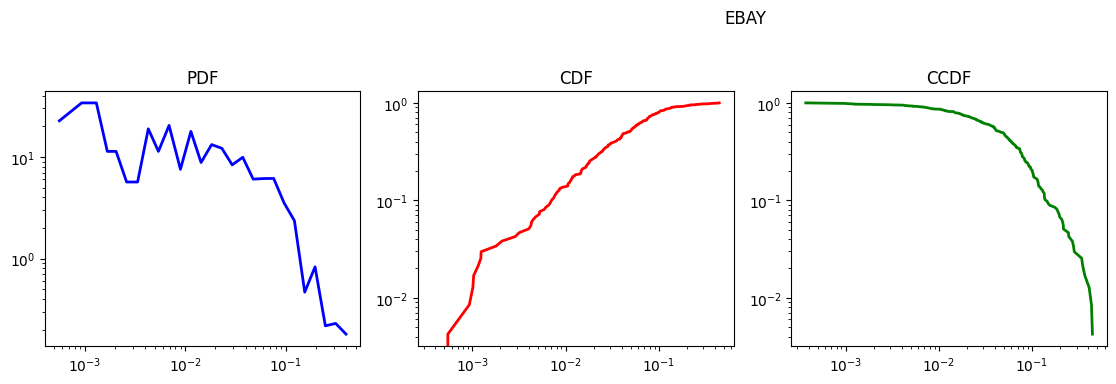

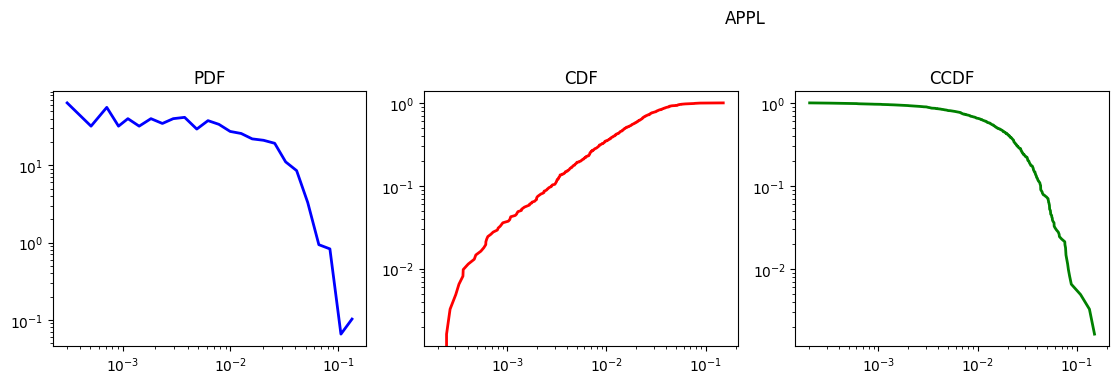

In [51]:
# Plot distribution of sign_imbalance for each stock
for stock_name, data in sign_imbalance.items():
    plot_distributions(stock_name, data)

#### 2.1.1. Fit power law distribution

In [52]:
# 1. Fit Powerlaw and retrieve fitted object/ results
sign_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_sign_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(sign_imbalance_data):
    sign_imbalance_fit_objects = fit_powerlaw(data_dict=sign_imbalance, filename=sign_imbalance_data)
else:
    sign_imbalance_fit_objects = load_fit_objects(sign_imbalance_data)

sign_imbalance_fit_objects

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


{'TSLA': <powerlaw.Fit at 0x16d234310>,
 'MSFT': <powerlaw.Fit at 0x282fcb950>,
 'AMZN': <powerlaw.Fit at 0x283e2e810>,
 'NFLX': <powerlaw.Fit at 0x3387befd0>,
 'EBAY': <powerlaw.Fit at 0x333ec3450>,
 'APPL': <powerlaw.Fit at 0x16d12cf50>}

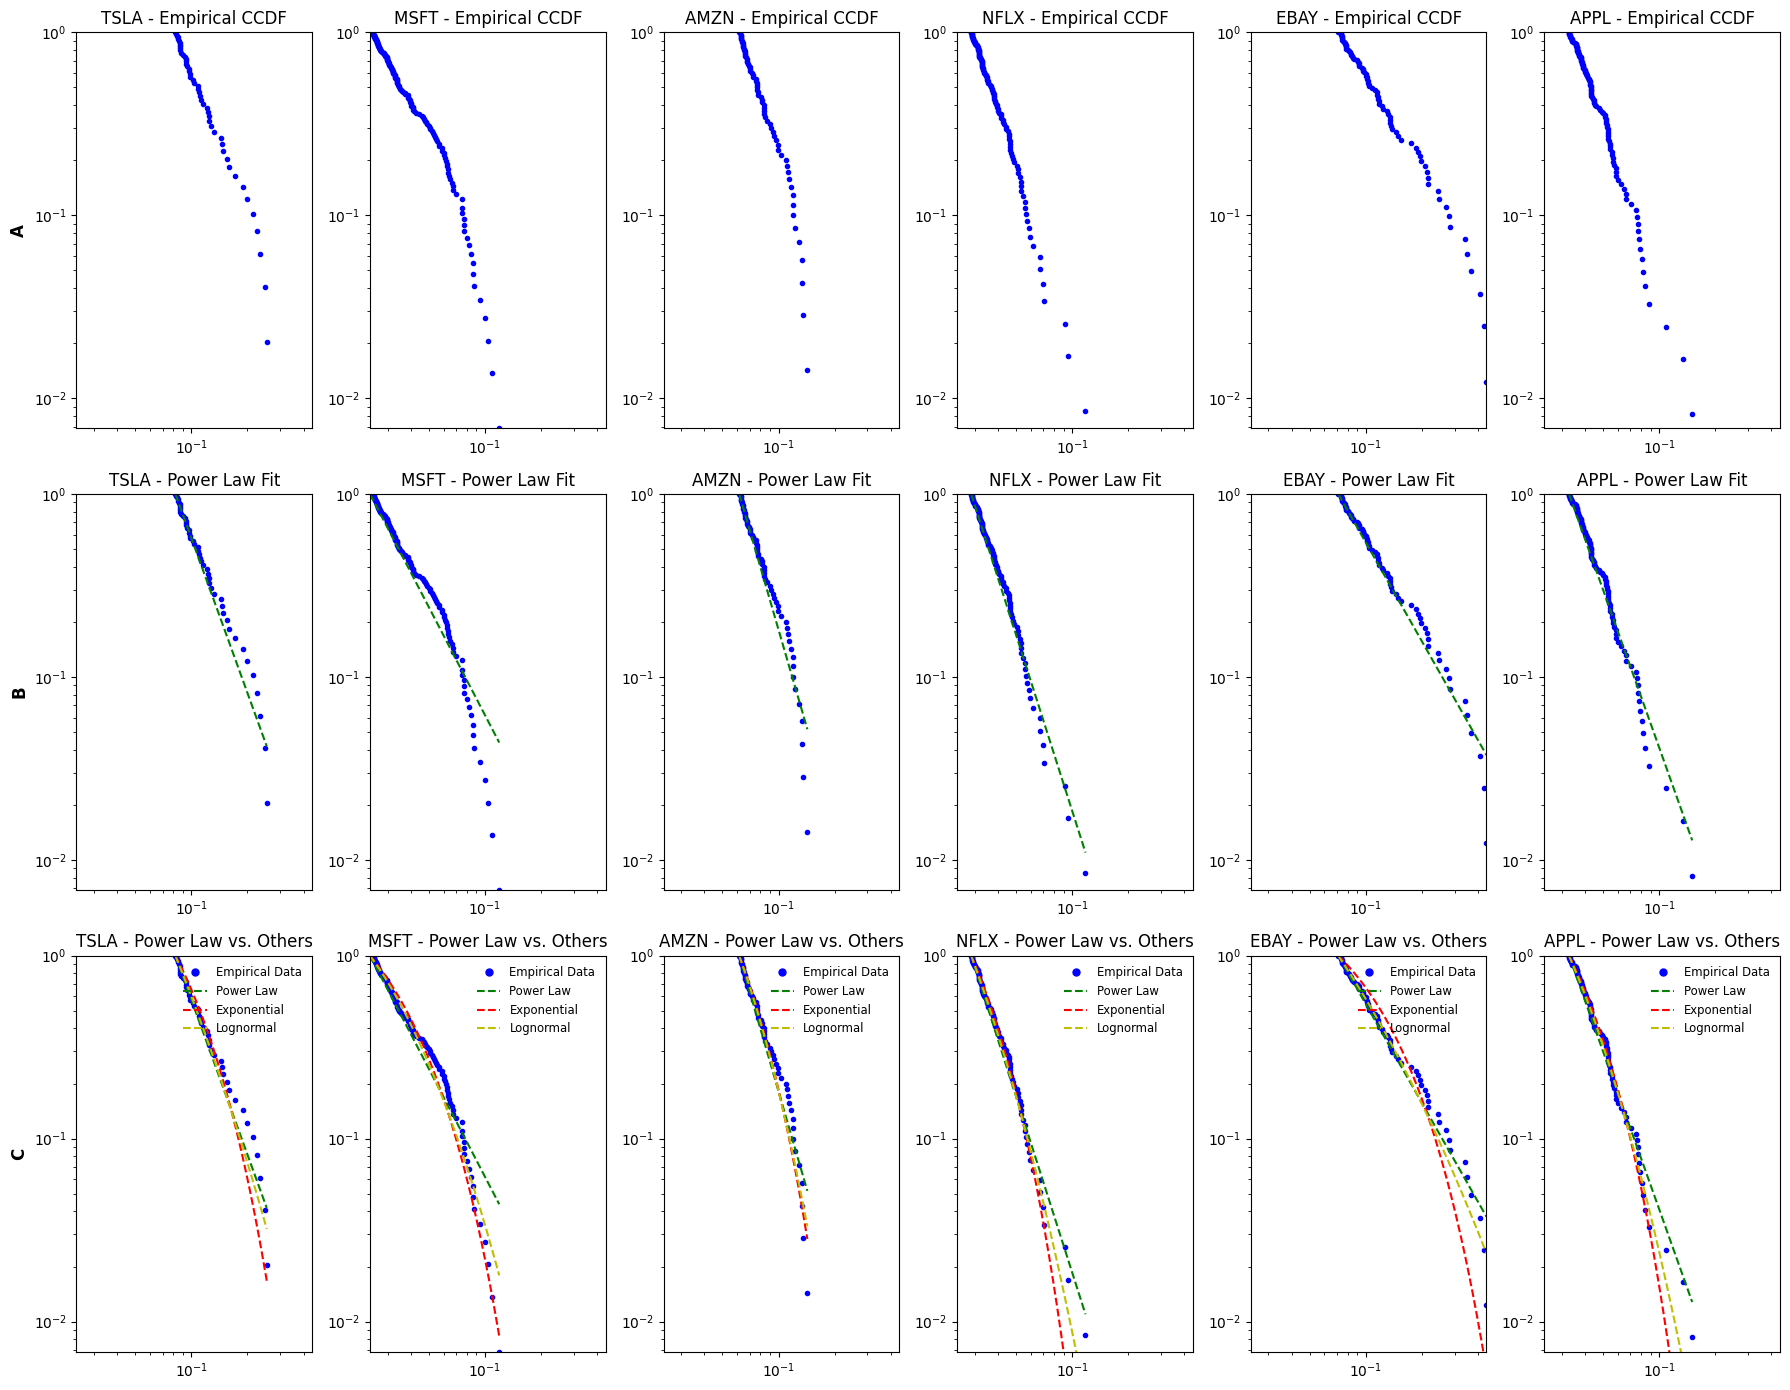

In [53]:
# Plot fitted objects
plot_fit_objects(sign_imbalance_fit_objects)

#### 2.1.2. Retrieve Power law fitting results

In [54]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_fit_results = get_fitting_params(sign_imbalance_fit_objects, 'power_law')
print(sign_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.813733  0.082103     0.058782
1  MSFT    power_law  2.959584  0.024173     0.068939
2  AMZN    power_law  4.518244  0.061538     0.067072
3  NFLX    power_law  4.195677  0.028738     0.057998
4  EBAY    power_law  2.794505  0.071279     0.054966
5  APPL    power_law  3.863469  0.032782     0.078163


In [55]:
# Average Alpha exponents across stocks
min_alpha = sign_imbalance_fit_results['alpha'].min()
max_alpha = sign_imbalance_fit_results['alpha'].max()
avg_alpha = sign_imbalance_fit_results['alpha'].mean()
std_dev_alpha = sign_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.79450483479269
Max Alpha: 4.518244255936405
Average Alpha: 3.6908684752970427
std_dev_alpha: 0.6815443260808078


#### 2.1.3. Compare alternative distributions

In [56]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
sign_imbalance_comparison = distribution_compare(sign_imbalance_fit_objects, 'exponential')
display(sign_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,23.839487,0.082103,3.813733,0.058782,0.111245,0.243533,0.807593
1,MSFT,exponential,50.347242,0.024173,2.959584,0.068939,0.092780,-1.472523,0.140880
2,AMZN,exponential,43.914169,0.061538,4.518244,0.067072,0.078516,-1.058807,0.289688
3,NFLX,exponential,81.309438,0.028738,4.195677,0.057998,0.074257,0.005956,0.995248
4,EBAY,exponential,13.980783,0.071279,2.794505,0.054966,0.126115,0.795854,0.426117
5,APPL,exponential,61.942786,0.032782,3.863469,0.078163,0.073211,-0.218746,0.826848


### 2.2. Volume Imbalance

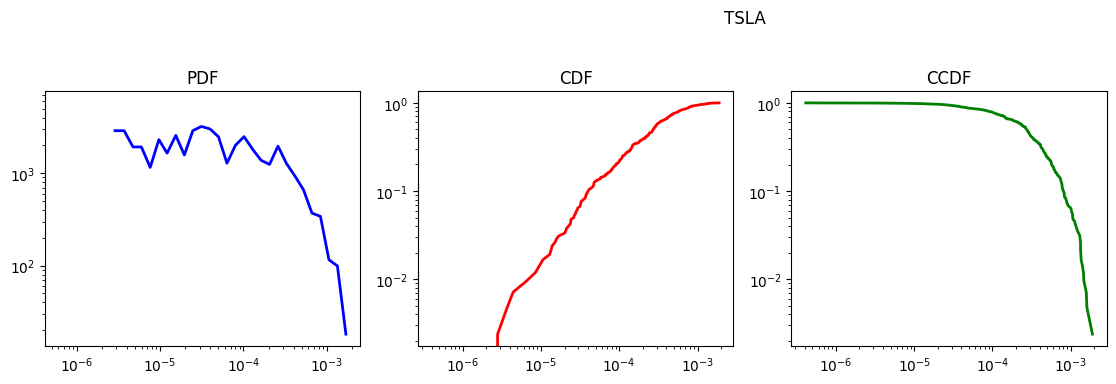

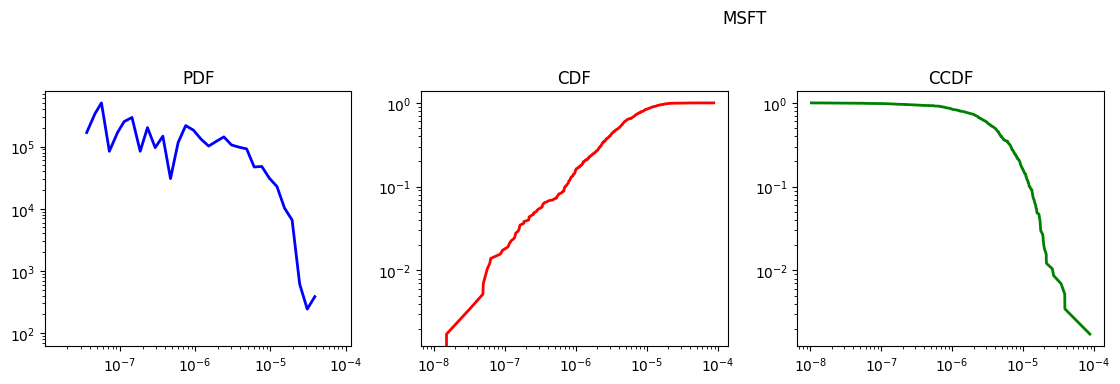

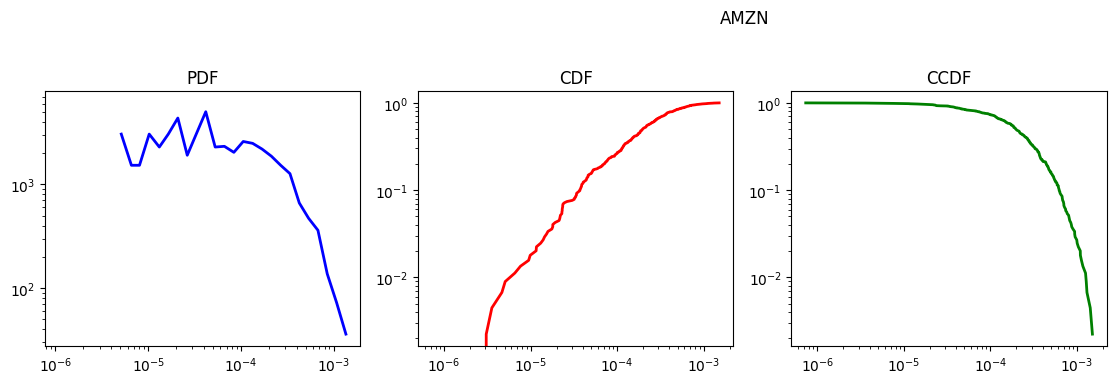

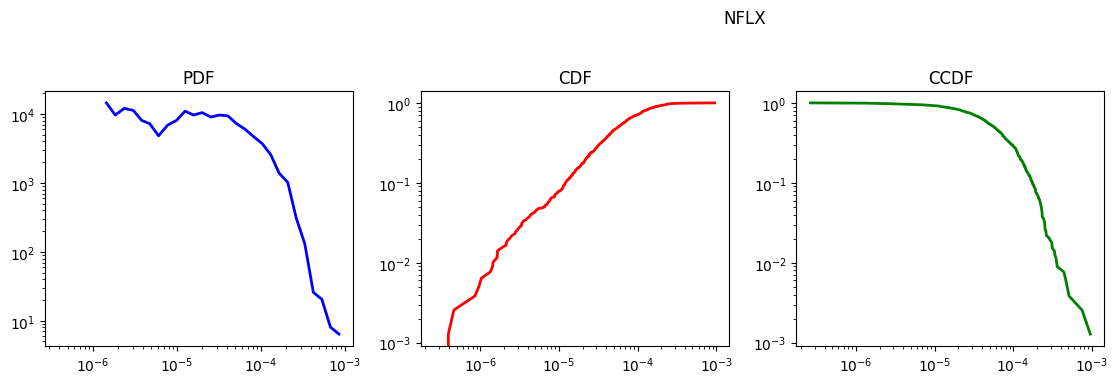

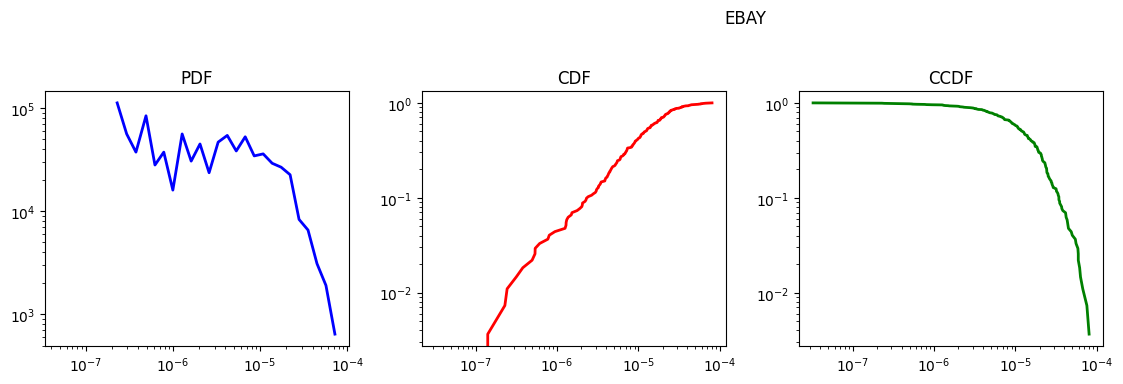

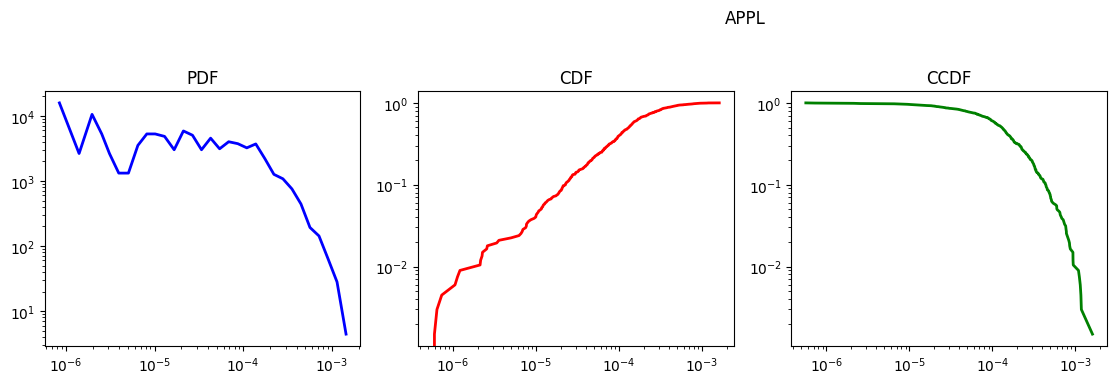

In [57]:
# Plot distribution of volume_imbalance for each stock
for stock_name, data in volume_imbalance.items():
    plot_distributions(stock_name, data)

#### 2.2.1. Fit power law distribution

In [58]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volume_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_volume_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(volume_imbalance_data):
    volume_imbalance_data_fit_objects = fit_powerlaw(data_dict=volume_imbalance, filename=volume_imbalance_data)
else:
    volume_imbalance_data_fit_objects = load_fit_objects(volume_imbalance_data)

volume_imbalance_data_fit_objects

Calculating best minimal value for power law fit


/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x283b923d0>,
 'MSFT': <powerlaw.Fit at 0x333e615d0>,
 'AMZN': <powerlaw.Fit at 0x283940310>,
 'NFLX': <powerlaw.Fit at 0x16c1cc2d0>,
 'EBAY': <powerlaw.Fit at 0x16c51a810>,
 'APPL': <powerlaw.Fit at 0x16c51b610>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1507: RuntimeWarning: overflow encountered in divide
  likelihoods = f/C
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: divide by zero encountered in divide
  CDF = CDF/norm
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


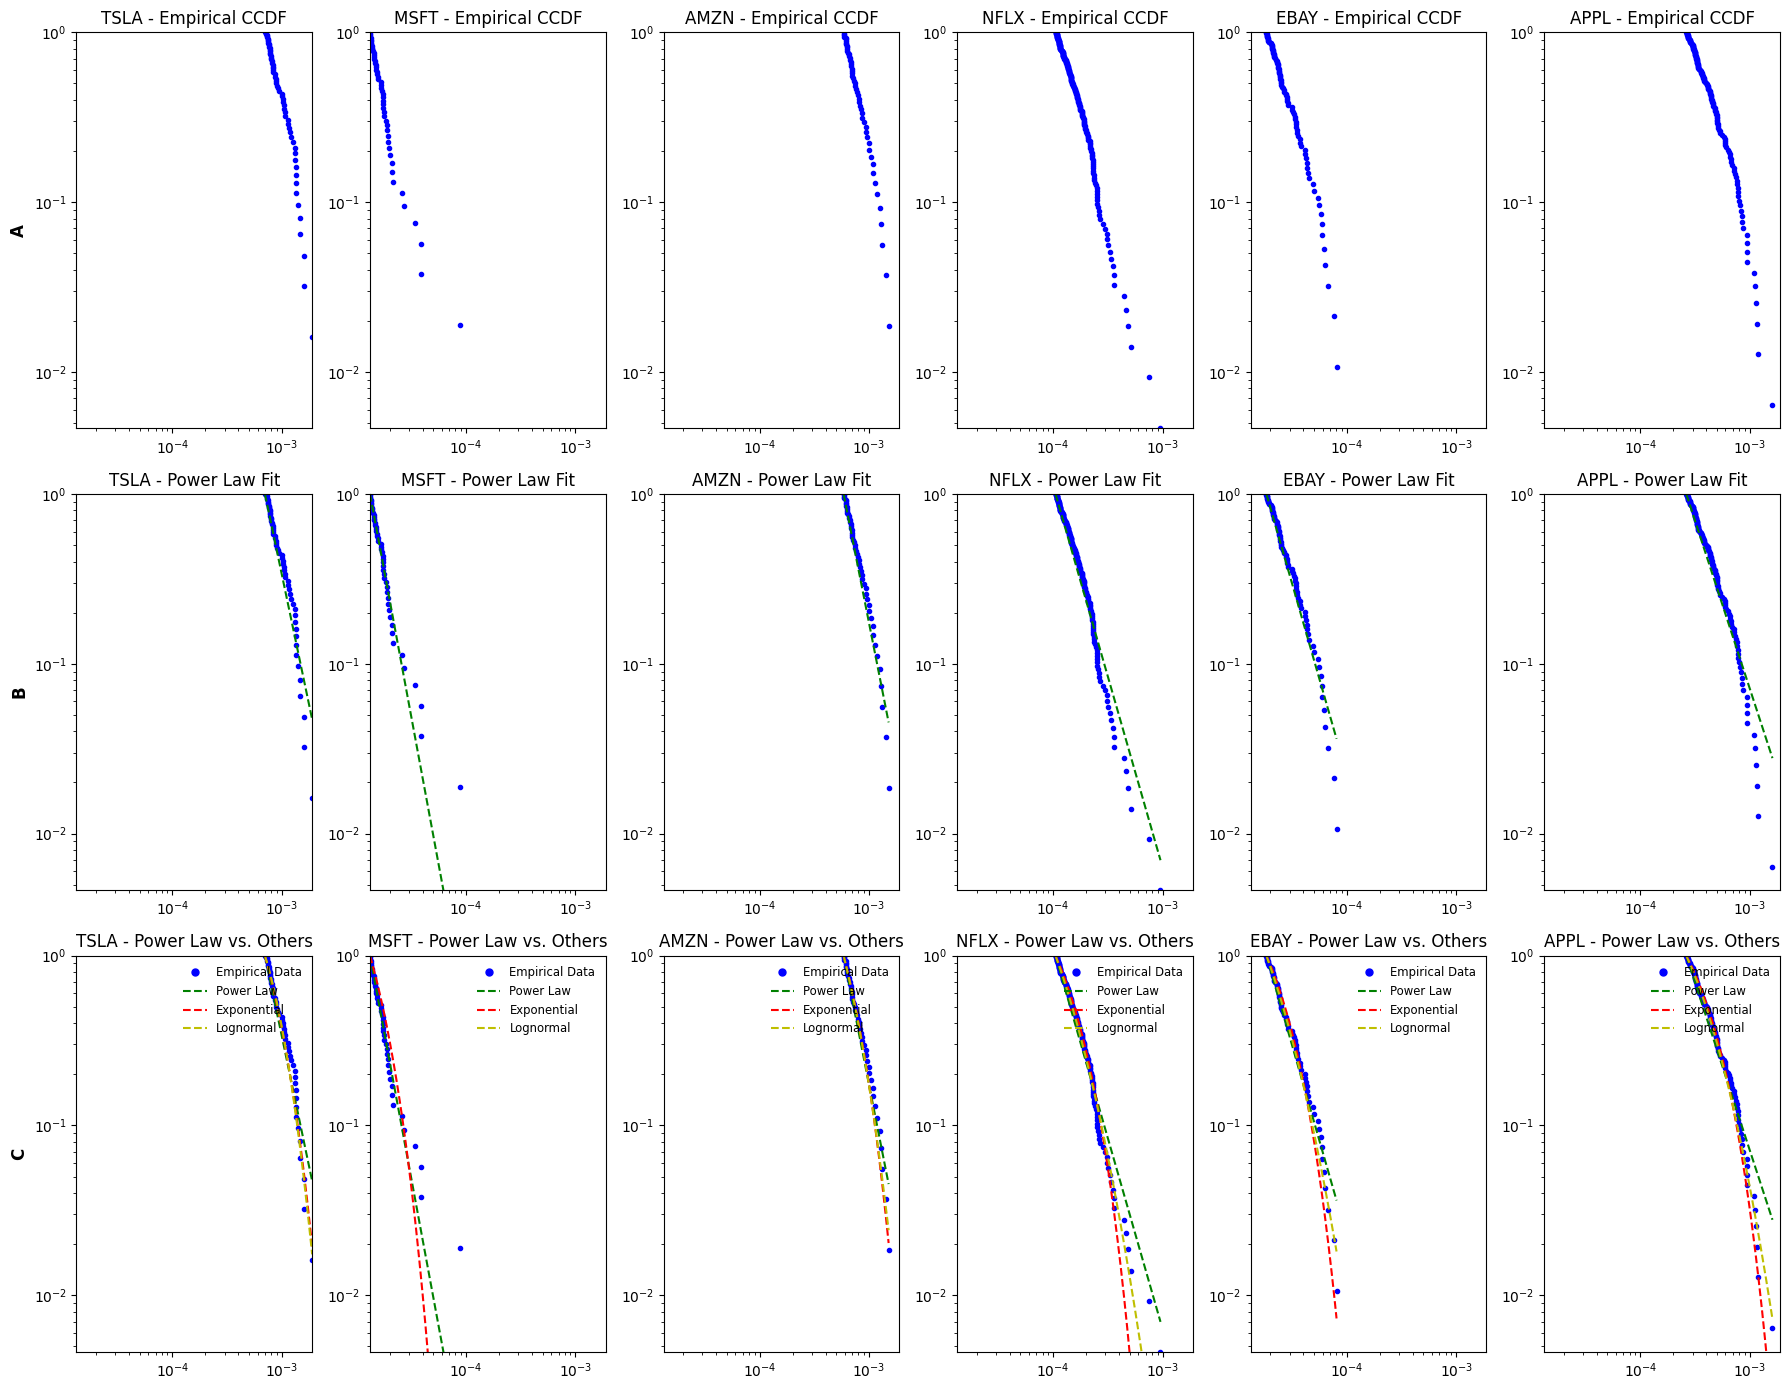

In [59]:
# Plot fitted objects
plot_fit_objects(volume_imbalance_data_fit_objects)

#### 2.2.2. Retrieve Power law fitting results

In [60]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'power_law')
print(volume_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  4.077860  0.000700     0.098852
1  MSFT    power_law  4.479644  0.000013     0.061927
2  AMZN    power_law  4.268800  0.000585     0.070151
3  NFLX    power_law  3.248452  0.000105     0.070630
4  EBAY    power_law  3.249998  0.000018     0.072017
5  APPL    power_law  2.975266  0.000263     0.076688


In [61]:
# Average Alpha exponents across stocks
min_alpha = volume_imbalance_fit_results['alpha'].min()
max_alpha = volume_imbalance_fit_results['alpha'].max()
avg_alpha = volume_imbalance_fit_results['alpha'].mean()
std_dev_alpha = volume_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.975266218090934
Max Alpha: 4.479644094618767
Average Alpha: 3.7166701010396164
std_dev_alpha: 0.6331074855000157


#### 2.2.3. Compare alternative distributions

In [62]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_imbalance_comparison = distribution_compare(volume_imbalance_data_fit_objects, 'exponential')
display(volume_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,3316.052624,0.000700,4.077860,0.098852,0.075452,-1.992370,0.046330
1,MSFT,exponential,171092.793542,0.000013,4.479644,0.061927,0.139413,1.523409,0.127656
2,AMZN,exponential,4215.319677,0.000585,4.268800,0.070151,0.054152,-1.055462,0.291214
3,NFLX,exponential,13651.757052,0.000105,3.248452,0.070630,0.062644,0.154582,0.877151
4,EBAY,exponential,79127.344089,0.000018,3.249998,0.072017,0.091342,-0.405783,0.684902
5,APPL,exponential,4662.187629,0.000263,2.975266,0.076688,0.085278,-1.228651,0.219203
